In [286]:
#Import relevant modules, import data and all that
import numpy as np
from scipy import interpolate
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from configparser import ConfigParser
import codecs
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})

import ptemcee
#from pycbc.pool import choose_pool
from multiprocessing import Pool
import h5py
import inspect
import pandas as pd
import json
import qnm
import random
import dynesty
from dynesty import plotting as dyplot
import os
import csv
import argparse
import scipy.optimize as optimization
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from pycbc.conversions import get_lm_f0tau_allmodes
from scipy.optimize import fsolve
from scipy.optimize import least_squares



try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    parser = ConfigParser()
    parser.read('config_fixed_n1_m_af.ini')
    parser.sections()
    pass

usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/francisco.jimenez/.local/share/jupyter/runtime/kernel-976255c1-9f4c-471c-966e-ca0fc33729f6.json


In [287]:
# path
rootpath=parser.get('nr-paths','rootpath')

simulation_path_1 = parser.get('nr-paths','simulation_path_1')
simulation_path_2 = parser.get('nr-paths','simulation_path_2')
metadata_file = parser.get('nr-paths','metadata_json')
simulation_number = parser.get('nr-paths','simulation_number')
simulation_number = np.int(simulation_number)

output_folder = parser.get('output-folder','output-folder')
overwrite = parser.get('setup','overwrite')
downfactor = np.int(parser.get('setup','plot_down_factor'))
sampler = parser.get('setup','sampler')
nr_code = parser.get('setup','nr_code')

In [288]:
if parser.has_option('setup','nb_cores'):
    nbcores = np.int(parser.get('setup','nb_cores'))
else:
    nbcores = 1

In [289]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    print("Directory " , output_folder ,  " Created ")

In [290]:
# time config
tshift=parser.get('time-setup','tshift')
tshift = np.float(tshift)

tend=parser.get('time-setup','tend')
tend = np.float(tend)

t_align=parser.get('time-setup','t_align')
t_align = np.float(t_align)

In [291]:
# n-tones & nlive

nmax=parser.get('n-tones','nmax')
nmax = np.int(nmax)

npoints=parser.get('n-live-points','npoints')
npoints = np.int(npoints)

In [292]:
# model
model=parser.get('rd-model','model')
error_str = eval(parser.get('rd-model','error_str'))
if error_str:
    error_val=np.float(parser.get('rd-model','error_val'))
    if error_val==0:
        error_type=''
    else:
        error_type=error_val
else:
    error_type='False'
    error_val =0

if model == 'w-q':
    tau_var_str='q'
else:
    tau_var_str='tau'
    

print('model:',model)
print('nmax:',nmax)
print('tshift:',tshift)
print('error:', error_str)
print('error value:',error_type)

model: w-tau-fixed-m-af
nmax: 1
tshift: 0.0
error: False
error value: False


In [293]:
if error_str:
    output_folder_1=output_folder+'/'+model+'-nmax'+str(nmax)+'_'+str(error_str)+'_'+str(error_type)
else:
    output_folder_1=output_folder+'/'+model+'-nmax'+str(nmax)+'_'+str(error_str)

if not os.path.exists(output_folder_1):
    os.mkdir(output_folder_1)
    print("Directory " , output_folder_1 ,  " Created ")

Directory  /work/francisco.jimenez/sio/git/rdstackingproject/results_new/0305/w-tau-fixed-m-af-nmax1_False  Created 


In [294]:
corner_plot=output_folder_1+'/Dynesty_'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'corner_plot.png'
corner_plot_extra=output_folder_1+'/Dynesty_'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'corner_plot_extra.png'
diagnosis_plot=output_folder_1+'/Dynesty_diagnosis'+str(simulation_number)+'_'+model+'_nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'.png'
fit_plot=output_folder_1+'/Fit_results_'+str(simulation_number)+'tshift_'+str(tshift)+'_'+model+'_nmax_'+str(nmax)+'.png'
samples_file=output_folder_1+'/posterior_samples-'+str(simulation_number)+'tshift_'+str(tshift)+'_'+model+'_nmax_'+str(nmax)+'.csv'

In [295]:
sumary_data = output_folder_1+'/summary'+str(simulation_number)+'_'+model+'_nmax_'+str(nmax)+'.csv'
best_data=output_folder_1+'/best_values_'+str(simulation_number)+'_'+model+'_nmax_'+str(nmax)+'.csv'

In [296]:
vary_fund = True

#sampler parameters
dim = nmax+1
ndim = 4*dim
numbins = 32 #corner plot parameter - how many bins you want
datacolor = '#105670' #'#4fa3a7'
pkcolor = '#f2c977' #'#ffb45f'
mediancolor = '#f7695c' #'#9b2814'

#Import data and necessary functions
#TimeOfMaximum
def FindTmaximum(y):
    #Determines the maximum absolute value of the complex waveform
    absval = np.sqrt(y[:,1]*y[:,1]+y[:,2]*y[:,2])
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=y[index,0]
    return timemax


def EasyMatchT(t,h1,h2,tmin,tmax):
    #Computes the match for complex waveforms
    pos = np.argmax(t >= (tmin));
    
    h1red=h1[pos:];
    h2red=h2[pos:];
    
    norm1=np.sum(np.abs(h1red)**2)
    norm2=np.sum(np.abs(h2red)**2)

    myTable=h1red*np.conjugate(h2red)
    res=((np.sum(myTable)/np.sqrt(norm1*norm2))).real
    
    return res

def EasySNRT(t,h1,h2,tmin,tmax):
    #Computes the match for complex waveforms
    pos = np.argmax(t >= (tmin));
    
    h1red=h1[pos:];
    h2red=h2[pos:];

    myTable=h1red*np.conjugate(h2red)
    res=2*np.sqrt((np.sum(myTable)).real)
    
    return res

def wRD_to_f_Phys(f,M):
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return (c**3/(M*MS*G*2*np.pi))*f

def tauRD_to_t_Phys(tau,M):
    c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;
    return ((M*MS*G)/c**3)*tau


def twopoint_autocovariance(t,n):
    #Computes the match for complex waveforms
    dt=t[1]-t[0]
    res = np.zeros(len(n))
    taus = np.zeros(len(n))
    for tau in range(0,int(len(n)/2)):
        ntau=np.roll(n, tau)
        taus[tau] = t[tau]
        res[tau]=np.sum(n*ntau).real
    return (taus[:int(len(n)/2)],res[:int(len(n)/2)])

def QNM_spectrum(mf,af,l,m):
    
    omegas_new = [qnm.modes_cache(s=-2,l=l,m=m,n=i)(a=af)[0] for i in range (0,dim)]
    w_m_a = (np.real(omegas_new))/mf
    tau_m_a=-1/(np.imag(omegas_new))*mf
    
    return (w_m_a, tau_m_a)

In [297]:
gw = {}
gw[simulation_number] = h5py.File(simulation_path_1, 'r')
if nr_code=='SXS':
    gw_sxs_bbh_0305 = gw[simulation_number]["Extrapolated_N3.dir"]["Y_l2_m2.dat"]
    times = gw_sxs_bbh_0305[:,0]

    gw5 = {}
    gw5[simulation_number] = h5py.File(simulation_path_2, 'r')
    gw5_sxs_bbh_0305 = gw5[simulation_number]["Extrapolated_N3.dir"]["Y_l2_m2.dat"]
# Remember to download metadata.json from the simulation with number: 0305. Download Lev6/metadata.json
# This postprocesses the metadata file to find the final mass and final spin
    
elif nr_code=='Maya':
    gw_sxs_bbh_0305_amp = np.asarray(gw[simulation_number]['amp_l2_m2/Y'])[6:]
    gw_sxs_bbh_0305_amp_err = np.asarray(gw[simulation_number]['amp_l2_m2/errors'])
    times = np.asarray(gw[simulation_number]['amp_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_amp_int = interp1d(times, -gw_sxs_bbh_0305_amp, kind='cubic')
    gw_sxs_bbh_0305_amp_errs_int = interp1d(times, gw_sxs_bbh_0305_amp_err, kind='cubic')

    
    gw_sxs_bbh_0305_pha = np.asarray(gw[simulation_number]['phase_l2_m2/Y'])[6:]
    gw_sxs_bbh_0305_pha_err = np.asarray(gw[simulation_number]['phase_l2_m2/errors'])
    times = np.asarray(gw[simulation_number]['phase_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_pha_int = interp1d(times, -gw_sxs_bbh_0305_pha, kind='cubic')
    gw_sxs_bbh_0305_pha_errs_int = interp1d(times, gw_sxs_bbh_0305_pha_err, kind='cubic')

    amps=gw_sxs_bbh_0305_amp_int(times) 
    amps_err=gw_sxs_bbh_0305_amp_errs_int(times) 

    phs=gw_sxs_bbh_0305_pha_int(times)
    phs_err=-gw_sxs_bbh_0305_pha_errs_int(times)
    
    gw_sxs_bbh_0305 = np.asarray([times,amps*np.cos(phs),amps*np.sin(phs)]).T
    gw5_sxs_bbh_0305 = np.asarray([times,(amps+amps_err)*np.cos(phs+phs_err),amps*np.sin(phs+phs_err)]).T

elif nr_code=='LaZeV':
    gw_sxs_bbh_0305_amp = np.asarray(gw[simulation_number]['amp_l2_m2/Y'])[6:]
    gw_sxs_bbh_0305_amp_err = np.asarray(gw[simulation_number]['amp_l2_m2/errors'])
    times_1 = np.asarray(gw[simulation_number]['amp_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_amp_int = interp1d(times_1, -gw_sxs_bbh_0305_amp, kind='cubic')
    gw_sxs_bbh_0305_amp_errs_int = interp1d(times_1, gw_sxs_bbh_0305_amp_err, kind='cubic')
    
    gw_sxs_bbh_0305_pha = np.asarray(gw[simulation_number]['phase_l2_m2/Y'])[6:]
    gw_sxs_bbh_0305_pha_err = np.asarray(gw[simulation_number]['phase_l2_m2/errors'])
    times = np.asarray(gw[simulation_number]['phase_l2_m2/X'])[6:]
    gw_sxs_bbh_0305_pha_int = interp1d(times, -gw_sxs_bbh_0305_pha, kind='cubic')
    gw_sxs_bbh_0305_pha_errs_int = interp1d(times, gw_sxs_bbh_0305_pha_err, kind='cubic')
    
    amps=gw_sxs_bbh_0305_amp_int(times_1) 
    amps_err=gw_sxs_bbh_0305_amp_errs_int(times_1) 

    phs=gw_sxs_bbh_0305_pha_int(times_1)
    phs_err=-gw_sxs_bbh_0305_pha_errs_int(times_1)
    
    gw_sxs_bbh_0305 = np.asarray([times_1,amps*np.cos(phs),amps*np.sin(phs)]).T
    gw5_sxs_bbh_0305 = np.asarray([times_1,(amps+amps_err)*np.cos(phs+phs_err),amps*np.sin(phs+phs_err)]).T
    times=times_1

In [298]:
if nr_code=='SXS':
    metadata = {}
    with open(metadata_file) as file:
        metadata[simulation_number] = json.load(file)

    af = metadata[simulation_number]['remnant_dimensionless_spin'][-1]
    mf = metadata[simulation_number]['remnant_mass']

elif nr_code=='Maya':
    af = 0.6861
    mf = 0.9515

elif nr_code=='LaZeV':
    af = 0.692
    mf = 0.952
    
#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305[round(len(gw_sxs_bbh_0305)/2):])
times = times - tmax


#times 6--> x axis of your data
times5 = gw5_sxs_bbh_0305[:,0]
tmax5=FindTmaximum(gw5_sxs_bbh_0305[round(len(gw_sxs_bbh_0305)/2):])
times5 = times5 - tmax5

In [299]:
w , tau = QNM_spectrum(mf,af,2,2)

In [300]:
# loading priors
w_mins=np.empty(nmax+1)
w_maxs=np.empty(nmax+1)
tau_mins=np.empty(nmax+1)
tau_maxs=np.empty(nmax+1)
a_mins=np.empty(nmax+1)
a_maxs=np.empty(nmax+1)
ph_mins=np.empty(nmax+1)
ph_maxs=np.empty(nmax+1)

for i in range(nmax+1): 
    wp_min=parser.get('prior-w'+str(i),'w'+str(i)+'_min')
    w_mins[i] = np.float(wp_min)
    
    wp_max=parser.get('prior-w'+str(i),'w'+str(i)+'_max')
    w_maxs[i] = np.float(wp_max)
    
    taup_min=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_min')
    tau_mins[i] = np.float(taup_min)
    
    taup_max=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_max')
    tau_maxs[i] = np.float(taup_max)
    
    amp0_min=parser.get('prior-amp'+str(i),'amp'+str(i)+'_min')
    a_mins[i] = np.float(amp0_min)
    
    amp1_max=parser.get('prior-amp'+str(i),'amp'+str(i)+'_max')
    a_maxs[i] = np.float(amp1_max)
    
    phase_min=parser.get('prior-phase'+str(i),'phase'+str(i)+'_min')
    ph_mins[i] = np.float(phase_min)*2*np.pi
    
    phase_max=parser.get('prior-phase'+str(i),'phase'+str(i)+'_max')
    ph_maxs[i] = np.float(phase_max)*2*np.pi
    
priors_min = np.concatenate((w_mins,tau_mins,a_mins,ph_mins))
priors_max = np.concatenate((w_maxs,tau_maxs,a_maxs,ph_maxs))
prior_dim = len(priors_min)
priors=np.column_stack((priors_min,priors_max))

if model == 'w-tau-fixed':
    priors_min = np.concatenate((a_mins,ph_mins))
    priors_max = np.concatenate((a_maxs,ph_maxs))
    prior_dim = len(priors_min)
    priors=np.column_stack((priors_min,priors_max))

elif model ==  'w-tau-fixed-m-af':
    mass_min=[np.float(parser.get('prior-mass','mass_min'))]
    mass_max=[np.float(parser.get('prior-mass','mass_max'))]
    spin_min=[np.float(parser.get('prior-spin','spin_min'))]
    spin_max=[np.float(parser.get('prior-spin','spin_max'))]
    priors_min = np.concatenate((a_mins,ph_mins,mass_min,spin_min))
    priors_max = np.concatenate((a_maxs,ph_maxs,mass_max,spin_max))
    prior_dim = len(priors_min)
    priors=np.column_stack((priors_min,priors_max))


In [301]:
#Select the data from 0 onwards
position = np.argmax(times >= (t_align))
position5 = np.argmax(times5 >= (t_align))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position+1:]
gw_sxs_bbh_0305rd5=gw5_sxs_bbh_0305[position5+1:]
timesrd=gw_sxs_bbh_0305[position:-1][:,0][:]-tmax
timesrd5=gw5_sxs_bbh_0305[position5:-1][:,0][:]-tmax5

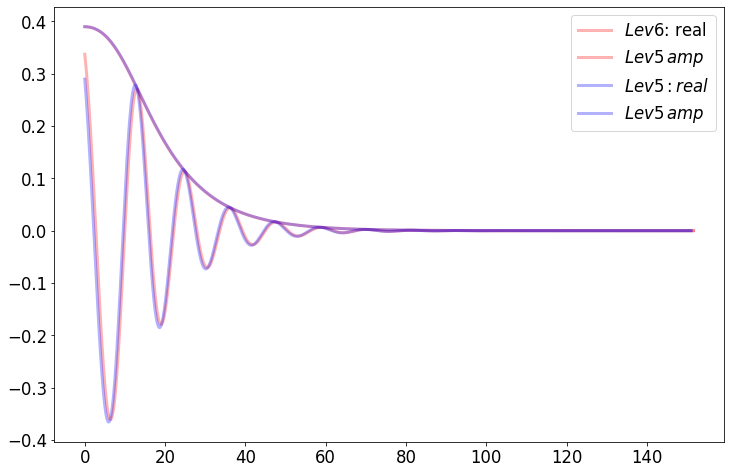

In [302]:
#Test plot real part (data was picked in the last cell). Aligning in time
plt.figure(figsize = (12, 8))
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$Lev6$: real')
plt.plot(timesrd, np.sqrt(gw_sxs_bbh_0305rd[:,1]**2+gw_sxs_bbh_0305rd[:,2]**2), "r", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.plot(timesrd5, gw_sxs_bbh_0305rd5[:,1], "b", alpha=0.3, lw=3, label=r'$Lev5: real$')
plt.plot(timesrd5, np.sqrt(gw_sxs_bbh_0305rd5[:,1]**2+gw_sxs_bbh_0305rd5[:,2]**2), "b", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.legend()

In [303]:
gwnew_re = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,1], kind = 'cubic')
gwnew_im = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,2], kind = 'cubic')

gwnew_re5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,1], kind = 'cubic')
gwnew_im5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,2], kind = 'cubic')

In [304]:
if timesrd5[-1]>= timesrd[-1]: 
    timesrd_final = timesrd
else:
    timesrd_final = timesrd5

gwdatanew_re = gwnew_re(timesrd_final)
gwdatanew_im = gwnew_im(timesrd_final)
gwdatanew_re5 = gwnew_re5(timesrd_final)
gwdatanew_im5 = gwnew_im5(timesrd_final)

gwdatanew = gwdatanew_re - 1j*gwdatanew_im
gwdatanew5 = gwdatanew_re5- 1j*gwdatanew_im5

In [305]:
#taus, corr= twopoint_autocovariance(timesrd,gwdatanew-gwdatanew5)
#plt.figure(figsize = (12, 8))
#plt.plot(taus, corr,'ro')
#plt.show()
#vmax=np.max(corr)
#index = np.argmax(corr == vmax)
#taus[index]

In [306]:
mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,0+90)
error=np.sqrt(2*mismatch)
print('error estimate:',error)
print('mismatch:', mismatch)
print('snr:', EasySNRT(timesrd_final,gwdatanew,gwdatanew,0,0+90)/error**2)

error estimate: 0.20053883528563624
mismatch: 0.02010791222885977
snr: 229.43188441714122


In [307]:
if error_str and error_val==0:
    error = np.sqrt(gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5+gwdatanew5*gwdatanew5)
    error_est=np.sqrt(error.imag**2+error.real**2)
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, gwdatanew.real, "r", alpha=0.3, lw=2, label='Lev6')
    plt.plot(timesrd_final, gwdatanew5.real, "b", alpha=0.3, lw=2, label='Lev5')
    plt.plot(timesrd_final, error_est, "b", alpha=0.3, lw=2, label='error')
    plt.legend()

In [308]:
if parser.has_option('rd-model','phase_alignment'):
    phase_alignment=eval(parser.get('rd-model','phase_alignment'))    
else:
    phase_alignment=False

In [309]:
# Phase alignement
if phase_alignment:
    phas = np.angle(gwdatanew)
    phas = np.unwrap(phas)
    phas5 = np.angle(gwdatanew5)
    phas5 = np.unwrap(phas5)
    position = np.argmax(timesrd_final >= (t_align))
    dphase = phas5[position]-phas[position]
    gwdatanew = (gwdatanew_re - 1j*gwdatanew_im)*np.exp(1j*dphase)
    gw_sxs_bbh_0305rd6=gw6_sxs_bbh_0305[position6:-1]
    timesrd=gw_sxs_bbh_0305[position:-1][:,0][:920]
    mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,+90)
    error=np.sqrt(2*mismatch)
    print('error estimate:',error)
    print('mismatch:', mismatch)
    print('snr:', EasySNRT(timesrd_final,gwdatanew,gwdatanew5,0,0+90)/error)
    if error_str:
        error = np.sqrt(gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5+gwdatanew5*gwdatanew5)
        error_est=np.sqrt(error.imag**2+error.real**2)
    else :
        error = 1 

    EasySNRT(timesrd_final,gwdatanew,gwdatanew5/error,0,0+90)

In [310]:
#Test the new interpolated data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, gwdatanew.real, "r", alpha=0.3, lw=2, label='Lev6')
    plt.plot(timesrd_final, gwdatanew5.real, "b", alpha=0.3, lw=2, label='Lev5')
    plt.plot(timesrd_final, error.real, "b", alpha=0.3, lw=2, label='error')
    plt.legend()

In [311]:
#Test the error data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.plot(timesrd_final, np.sqrt(error.imag**2+error.real**2), "r", alpha=0.3, lw=2, label='all error')
    plt.legend()

In [312]:
#Test the error data
if error_str and error_val==0:
    plt.figure(figsize = (12, 8))
    plt.xlim(1,40)
    plt.ylim(-300,300)
    plt.plot(timesrd_final,gwdatanew.real/np.sqrt(error.imag**2+error.real**2), "r", alpha=0.3, lw=2, label='all error')
    plt.legend()

In [313]:
#Take the piece of waveform you want
tshift=0
position_in = np.argmax(timesrd_final >= tshift)
position_end = np.argmax(timesrd_final >= tend)
timesrd_final_tsh = timesrd_final[position_in:position_end]
gwdatanew_re_tsh = gwdatanew_re[position_in:position_end]
gwdatanew_im_tsh = gwdatanew_im[position_in:position_end]
if error_str and error_val==0:
    error_tsh=error[position_in:position_end]
elif error_str and error_val!=0:
    gwdatanew_re_tsh+=random.uniform(0, error_val)
    gwdatanew_im_tsh+=random.uniform(0, error_val)
    error_tsh=error_val
else:
    error_tsh=1

In [314]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv_q(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    qvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh*np.pi*wvars[i]/qvars[i])*(np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv_tau(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    tvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    xvars = theta[ : (dim)]
    yvars = theta[(dim) : 2*(dim)]
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tau[i]) * (np.cos(w[i]*timesrd_final_tsh)-1j*np.sin(w[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv_ma(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    xvars = theta[ : (dim)]
    yvars = theta[(dim) : 2*(dim)]
    mass_vars = np.float(theta[-2])
    spin_vars = np.float(theta[-1])
    
    w_m_a , tau_m_a = QNM_spectrum(mass_vars,spin_vars,2,2)
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tau_m_a[i]) * (np.cos(w_m_a[i]*timesrd_final_tsh)-1j*np.sin(w_m_a[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version. 

def prior_transform(cube):
    for i in range(prior_dim):
        cube[i] =  priors_min[i]+ cube[i]*(priors_max[i]-priors_min[i])
    return cube

# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    modelev = dict[model](theta)
    result = -np.sum(((gwdatanew_re_tsh - modelev.real)**2+(gwdatanew_im_tsh - modelev.imag)**2)/(2*(error_tsh.real**2+error_tsh.imag**2)))
    if np.isnan(result):
        return -np.inf
    return result


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [315]:
dict = {'w-tau': model_dv_tau , 'w-q': model_dv_q, 'w-tau-fixed': model_dv,'w-tau-fixed-m-af': model_dv_ma}

In [316]:
#nmax=2
#dim = nmax+1
#ndim = 4*dim

# loading priors
#w_mins=np.empty(nmax+1)
#w_maxs=np.empty(nmax+1)
#tau_mins=np.empty(nmax+1)
#tau_maxs=np.empty(nmax+1)
#a_mins=np.empty(nmax+1)
#a_maxs=np.empty(nmax+1)
#ph_mins=np.empty(nmax+1)
#ph_maxs=np.empty(nmax+1)


#for i in range(nmax+1): 
#    wp_min=parser.get('prior-w'+str(i),'w'+str(i)+'_min')
#    w_mins[i] = np.float(wp_min)
    
#    wp_max=parser.get('prior-w'+str(i),'w'+str(i)+'_max')
#    w_maxs[i] = np.float(wp_max)
    
#    taup_min=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_min')
#    tau_mins[i] = np.float(taup_min)
    
#    taup_max=parser.get('prior-'+tau_var_str+str(i),tau_var_str+str(i)+'_max')
#    tau_maxs[i] = np.float(taup_max)
    
#    amp0_min=parser.get('prior-amp'+str(i),'amp'+str(i)+'_min')
#    a_mins[i] = np.float(amp0_min)
    
#    amp1_max=parser.get('prior-amp'+str(i),'amp'+str(i)+'_max')
#    a_maxs[i] = np.float(amp1_max)
    
#    phase_min=parser.get('prior-phase'+str(i),'phase'+str(i)+'_min')
#    ph_mins[i] = np.float(phase_min)*2*np.pi
    
#    phase_max=parser.get('prior-phase'+str(i),'phase'+str(i)+'_max')
#    ph_maxs[i] = np.float(phase_max)*2*np.pi
    
#priors_min = np.concatenate((w_mins,tau_mins,a_mins,ph_mins))
#priors_max = np.concatenate((w_maxs,tau_maxs,a_maxs,ph_maxs))
#prior_dim = len(priors_min)

#nll = lambda *args: -log_likelihood(*args)
#initial = [w[0],w[1],w[2],tau[0],tau[1],tau[2],a_maxs[0]/2,a_maxs[1]/2,a_maxs[2]/2,1,1,1]
#bic2=np.ones(len(range(20)))

#for tshift in range(20):
#    position_in = np.argmax(timesrd_final >= tshift)
#    position_end = np.argmax(timesrd_final >= tend)
#    timesrd_final_tsh = timesrd_final[position_in:position_end]
#    gwdatanew_re_tsh = gwdatanew_re[position_in:position_end]
#    gwdatanew_im_tsh = gwdatanew_im[position_in:position_end]
#    error_tsh=error[position_in:position_end]

#    soln = minimize(nll, initial)
#    vars_ml=soln.x
#    initial = vars_ml
#    bic2[tshift]=2*log_likelihood(vars_ml)+len(timesrd_final_tsh)*np.log(len(timesrd_final_tsh))

In [317]:
#plt.figure(figsize = (12, 8))
#plt.plot(np.abs(bic4), "r", alpha=0.3, lw=3, label=r'$bic: 4$')
#plt.plot(np.abs(bic3), "b", alpha=0.3, lw=3, label=r'$bic: 3$')
#plt.plot(np.abs(bic2), "cyan", alpha=0.3, lw=3, label=r'$bic: 2$')
#plt.yscale('log')
#plt.legend()

In [322]:
nll = lambda *args: -log_likelihood(*args)
if model == 'w-tau-fixed-m-af':
    initial = np.concatenate((np.ones(2*dim),[0.8,0.9]))
    soln = minimize(nll, initial,bounds=priors)
    vars_ml=soln.x
elif model == 'w-tau-fixed':
    initial = np.ones(2*dim)
    soln = minimize(nll, initial,bounds=priors)
    vars_ml=soln.x
else:
    initial = np.ones(ndim)
    soln = minimize(nll, initial,bounds=priors)
    vars_ml=soln.x

In [323]:
mypool = Pool(nbcores)
mypool.size = nbcores

f2=dynesty.NestedSampler(log_likelihood, prior_transform, prior_dim, nlive=npoints,sample=sampler,pool=mypool)
if parser.has_option('setup','dlogz'):
    dlogz=np.float(parser.get('setup','dlogz'))    
    f2.run_nested(dlogz=dlogz)
else:
    f2.run_nested()

28308it [54:09,  8.71it/s, +2000 | bound: 106 | nc: 1 | ncall: 600714 | eff(%):  5.045 | loglstar:   -inf < -0.147 <    inf | logz: -9.689 +/-  0.083 | dlogz:  0.000 >  0.010]


In [325]:
wstr = r'$\omega_'

if model == 'w-tau':
    taustr = r'$\tau_'
elif model == 'w-q':
    taustr = r'$q_'
elif model == 'w-tau-fixed':
    taustr = r'$dumb_var}'  
elif model == 'w-tau-fixed-m-af':
    taustr = r'$\tau_'
    
ampstr = r'$A_'
phasestr =  r'$\phi_'

w_lab = [None] * dim
tau_lab = [None] * dim
amp_lab =  [None] * dim
pha_lab =  [None] * dim
mass_lab =  ['mass']
spin_lab  =  ['spin'] 

for i in range(dim):
    w_lab[i] = wstr+str(i)+'$'
    tau_lab[i] = taustr+str(i)+'$'
    amp_lab[i] = ampstr+str(i)+'$'
    pha_lab[i] = phasestr+str(i)+'$'


labels = np.concatenate((w_lab,tau_lab,amp_lab,pha_lab))

if model=='w-tau-fixed':
    labels = np.concatenate((amp_lab,pha_lab))
    
if model=='w-tau-fixed-m-af':
    pha_lab[i] = phasestr+str(i)+'$'

    labels = np.concatenate((amp_lab,pha_lab,mass_lab,spin_lab))

In [337]:
if model=='w-tau-fixed':
    rg = (nmax+1)
elif  model=='w-tau-fixed':
    rg = (nmax+1)+2
else:
    rg = (nmax+1)*2

samps=f2.results.samples
samps_tr=np.transpose(samps)
half_points=int(round((len(samps_tr[0])/1.25)))

if model=='w-tau-fixed-a-mf':
    npamps = np.empty((nmax+1))
    for i in range(0,(nmax+1)):
        amps_aux = samps_tr[i+rg][half_points:-1]
        npamps[i] = np.quantile(amps_aux, 0.5)
else :
    npamps = np.empty((nmax+1)*2)
    for i in range(0,(nmax+1)*2):
        amps_aux = samps_tr[i][half_points:-1]
        npamps[i] = np.quantile(amps_aux, 0.5)

In [338]:
res = f2.results
res.samples_u.shape
res.summary()
samps=f2.results.samples

Summary
nlive: 2000
niter: 28308
ncall: 600714
eff(%):  5.045
logz: -9.689 +/-  0.083


In [339]:
evidence = res.logz[-1]
evidence_error = res.logzerr[-1]

In [340]:
summary_titles=['n','id','t_shift','dlogz','dlogz_err']

In [341]:
if not eval(overwrite):
    if os.path.exists(sumary_data):
        outvalues = np.array([[nmax, simulation_number, tshift, evidence,evidence_error]])
    else:
        outvalues = np.array([summary_titles,[nmax, simulation_number, tshift, evidence,evidence_error]])

    with open(sumary_data, 'a') as file:
        writer = csv.writer(file)
        if (outvalues.shape)[0]>1 :
            writer.writerows(outvalues)
        else:
            writer.writerow(outvalues[0])

In [342]:
samps=f2.results.samples
samps_tr=np.transpose(samps)

In [343]:
sigma_vars_m = np.empty(prior_dim)
sigma_vars_p = np.empty(prior_dim)
sigma_vars = np.empty(prior_dim)
for i in range(prior_dim): 
    amps_aux = samps_tr[i][half_points:]
    sigma_vars_m[i] = np.quantile(amps_aux, 0.1)
    sigma_vars[i] = np.quantile(amps_aux, 0.5)
    sigma_vars_p[i] = np.quantile(amps_aux, 0.9)

In [344]:
sigma_vars_all = [sigma_vars,sigma_vars_m,sigma_vars_p]
sigma_vars_all=np.stack([sigma_vars,sigma_vars_m,sigma_vars_p], axis=0)

In [345]:
key =['max val','lower bound','higher bound']
dfslist = [pd.DataFrame(np.concatenate(([tshift],sigma_vars_all[i])).reshape((-1,prior_dim+1)), columns=np.concatenate((['tshift'],labels)), index = [key[i]]) for i in range(3)]
df2 = pd.concat(dfslist)
if not eval(overwrite):
    if os.path.exists(best_data):
        df2.to_csv(best_data, mode='a', header=False,index = True)
    else:
        df2.to_csv(best_data,index = True)

In [346]:
if model == 'w-q':
    tau_val = np.pi*w*tau
    truths = np.concatenate((w,tau_val,npamps))
elif model == 'w-tau':
    tau_val = tau
    truths = np.concatenate((w,tau_val,npamps))
elif model == 'w-tau-fixed':
    truths = npamps
elif model == 'w-tau-fixed-m-af':
    truths = np.concatenate((npamps,[mf],[af]))

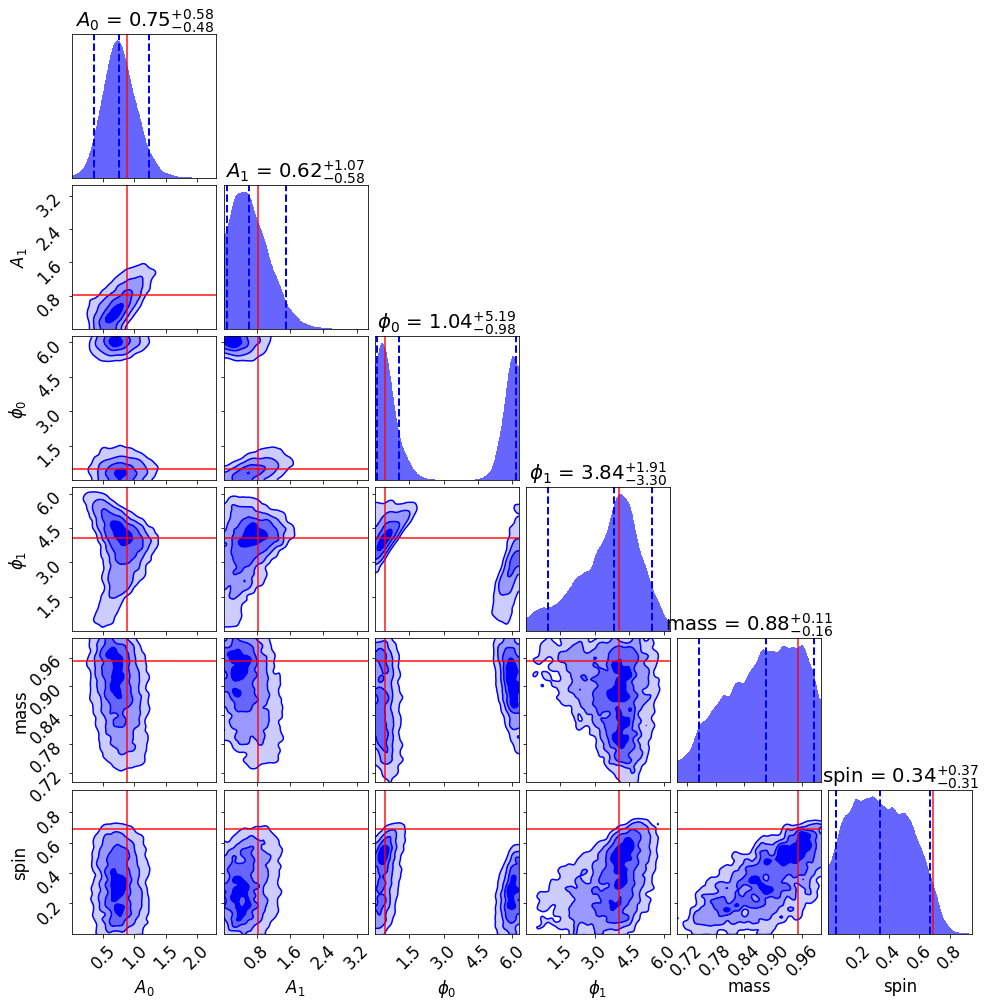

In [347]:
fg, ax = dyplot.cornerplot(res, color='blue', 
                           show_titles=True,
                           labels=labels,
                           quantiles=(0.05,0.5,0.95),
                           truths =truths,
                           truth_color='red',
)

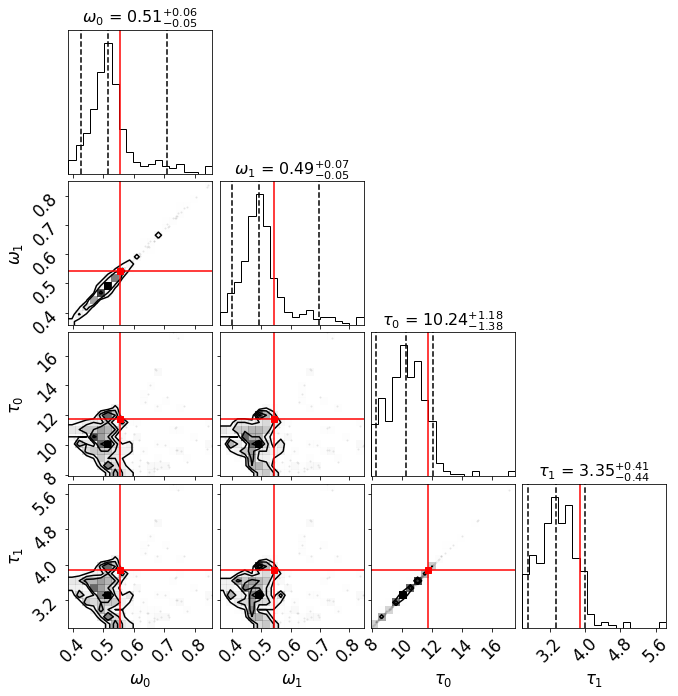

In [364]:
afdist=samps_tr[-1][::downfactor]
mdist=samps_tr[-2][::downfactor]

w_dist=[None] * len(afdist)
tau_dist=[None] * len(afdist)

for i in range(len(afdist)):
    w_dist[i],tau_dist[i] = QNM_spectrum(mdist[i],afdist[i],2,2)

for i in range(dim):
    w_lab[i] = wstr+str(i)+'$'
    tau_lab[i] = taustr+str(i)+'$'

labels = np.concatenate((w_lab,tau_lab))
truths = np.concatenate((w,tau))

w_tau_dist=np.column_stack((w_dist,tau_dist))
figure = corner.corner(w_tau_dist, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],
                       show_titles=True, title_kwargs={"fontsize": 16},
                       truths=truths,
                       truth_color ='r')

In [365]:
if not eval(overwrite):
    fg.savefig(corner_plot, format = 'png', bbox_inches = 'tight')
    if model == 'w-tau-fixed-m-af':
        figure.savefig(corner_plot_extra, format = 'png', bbox_inches = 'tight')

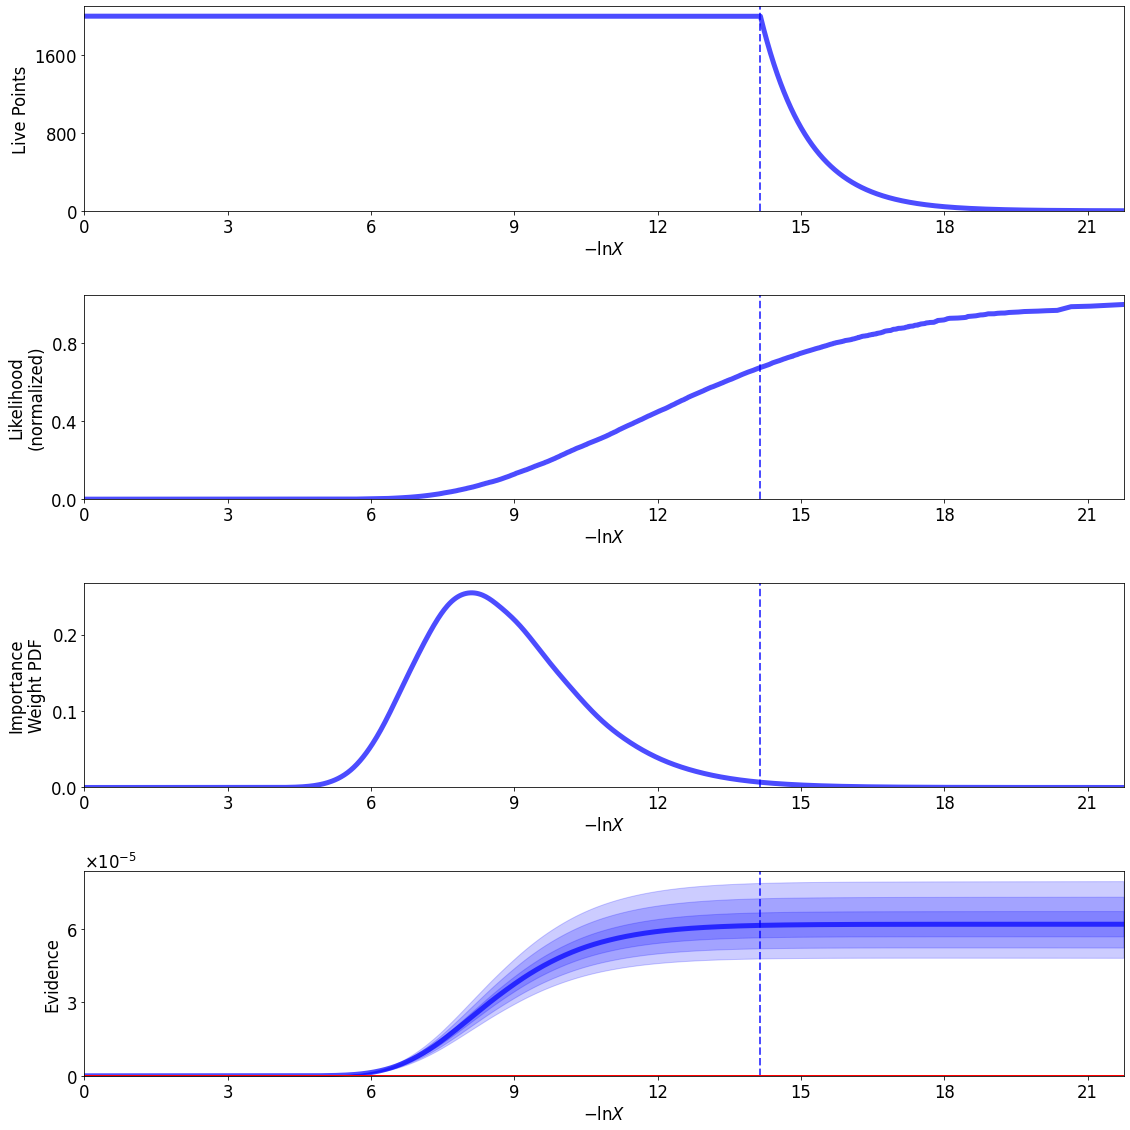

In [366]:
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth)
fig.tight_layout()

In [367]:
if not eval(overwrite):
    fig.savefig(diagnosis_plot, format = 'png', dpi = 384, bbox_inches = 'tight')

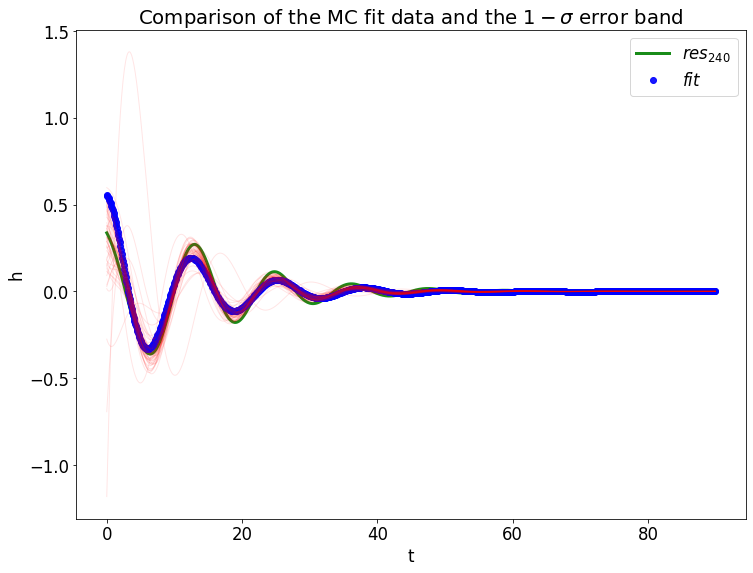

In [368]:
figband = plt.figure(figsize = (12, 9))
plt.plot(timesrd_final_tsh,gwdatanew_re_tsh, "green", alpha=0.9, lw=3, label=r'$res_{240}$')
plt.plot(timesrd_final_tsh,dict[model](vars_ml).real,'bo', alpha=0.9, lw=3, label=r'$fit$')
onesig_bounds = np.array([np.percentile(samps[:, i], [16, 84]) for i in range(len(samps[0]))]).T
samples_1sigma = filter(lambda sample: np.all(onesig_bounds[0] <= sample) and np.all(sample <= onesig_bounds[1]), samps)
samples_1sigma_down = list(samples_1sigma)[::downfactor]
for sample in samples_1sigma_down:
    plt.plot(timesrd_final_tsh, dict[model](sample).real, "r-", alpha=0.1, lw=1)
plt.title(r'Comparison of the MC fit data and the $1-\sigma$ error band')
plt.legend()
plt.xlabel('t')
plt.ylabel('h')
plt.show()

In [371]:
if not eval(overwrite):
    figband.savefig(fit_plot)

In [372]:
if not eval(overwrite):
    with open(samples_file,'w') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
        writer.writerows(samps[::downfactor])